# <div align="center"> 水果 </div>

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision

CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
pandas 1.1.5
matplotlib 3.3.3
sklearn 0.24.0
torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101


In [2]:
import pandas as pd  
import argparse      
import shutil        
import os            
import random
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
import torch

from tqdm import tqdm
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from IPython.display import display, Markdown
from PIL import Image
from torchvision.utils import make_grid

from k12libs.utils.nb_dataset import k12ai_compute_mean_std

In [3]:
dataset = 'cleaner_robot'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
train_path = os.path.join(data_root, 'train')
test_path = os.path.join(data_root, 'test')

## 预处理数据集

In [4]:
label2id = {
    "ring": 0,
    "cable": 1,
    "other": 2,
}

raw_path = os.path.join(data_root, 'raw')
img_path = os.path.join(data_root, 'imgs')

In [5]:
!ls $raw_path

cable  other  ring


In [6]:
label_image_dict = {}
with os.scandir(raw_path) as it:
    for entry in it:
        if not entry.is_dir():
            continue
        label_image_dict[entry.name] = []
        with os.scandir(os.path.join(entry.path)) as imgit:
            for imgentry in imgit:
                if not imgentry.is_file():
                    continue
                label_image_dict[entry.name].append(imgentry.path)
len(label_image_dict), len(label_image_dict['ring']), label_image_dict.keys()

(3, 32, dict_keys(['cable', 'ring', 'other']))

## 裁剪

In [7]:
if os.path.exists(img_path):
    shutil.rmtree(img_path)
os.makedirs(img_path)

label_images = {}
for label, files in label_image_dict.items():
    d = os.path.join(img_path, label)
    os.makedirs(d)
    label_images[label] = []
    for img in files:
        dst = os.path.join(d, os.path.basename(img))
        image = Image.open(img).convert('RGB')
        image.resize((256, 256)).crop((16, 16, 240, 240)).save(dst)
        label_images[label].append(dst)
len(label_images), len(label_images['ring'])

(3, 32)

## 对比

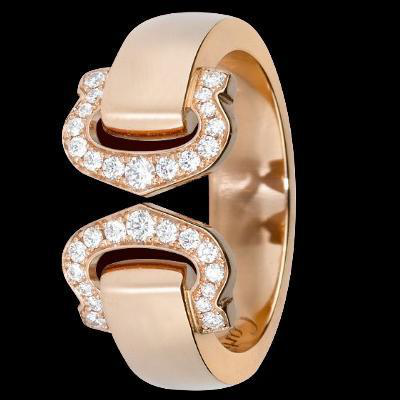

In [8]:
Image.open(label_image_dict['ring'][0])

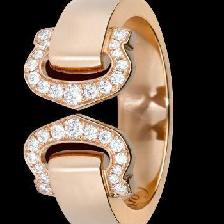

In [9]:
Image.open(label_images['ring'][0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  after removing the cwd from sys.path.


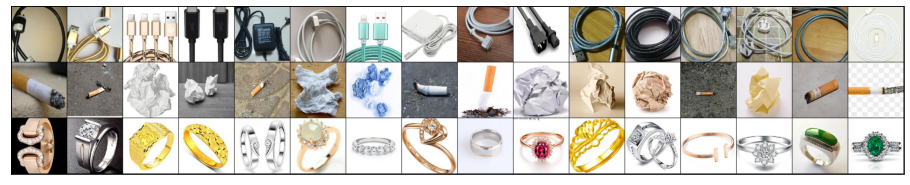

In [10]:
samples = []
for label in sorted(list(label_images.keys())):
    for img in label_images[label][:16]:
        samples.append(torch.from_numpy(np.asarray(Image.open(img))).permute(2, 0, 1))
    
fig, ax = plt.subplots(figsize=(16, 22))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(samples, nrow=16).permute(1, 2, 0));

## 切割数据集

In [11]:
# 6:2:2 split for train:valid:test dataset
all_images = []
test_images = []
valid_images = []
train_images = []
for label, files in label_images.items():
    for img in files:
        all_images.append((label, img))
        value = random.random()
        if value < 0.2: # test
            test_images.append((label, img))
        elif value < 0.4: # val
            valid_images.append((label, img))
        else: # train
            train_images.append((label, img))
test_count, val_count, train_count = len(test_images), len(valid_images), len(train_images)
test_count, val_count, train_count

(17, 23, 56)

## 生成json文件

In [12]:
def generate_json_file(images, phase):
    prefix = len(data_root) + 1
    items = []
    for label, img in images:
        items.append({'image_path': img[prefix:], 'label': label2id[label]})
        
    random.shuffle(items)

    jsonfile = os.path.join(data_root, f'{phase}.json')
    with open(jsonfile, 'w') as fp:
        json.dump(items, fp)
    return len(items)
        
# train.json
generate_json_file(train_images, 'train');

# val.json
generate_json_file(valid_images, 'val');

# test.json
generate_json_file(test_images, 'test');

# all.json
generate_json_file(all_images, 'all');

## 生成info.json

In [13]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles)

In [14]:
label_names = [
    "ring",
    "cable",
    "other",
]

info = {
    'num_records': test_count+val_count+train_count,
    'num_classes': len(label_names),
    'label_names': label_names,
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, indent=4)
    
info

{'num_records': 96,
 'num_classes': 3,
 'label_names': ['ring', 'cable', 'other'],
 'mean': [0.7566, 0.7323, 0.7016],
 'std': [0.1805, 0.194, 0.2195]}

## 数据平衡分析

<Figure size 432x288 with 0 Axes>

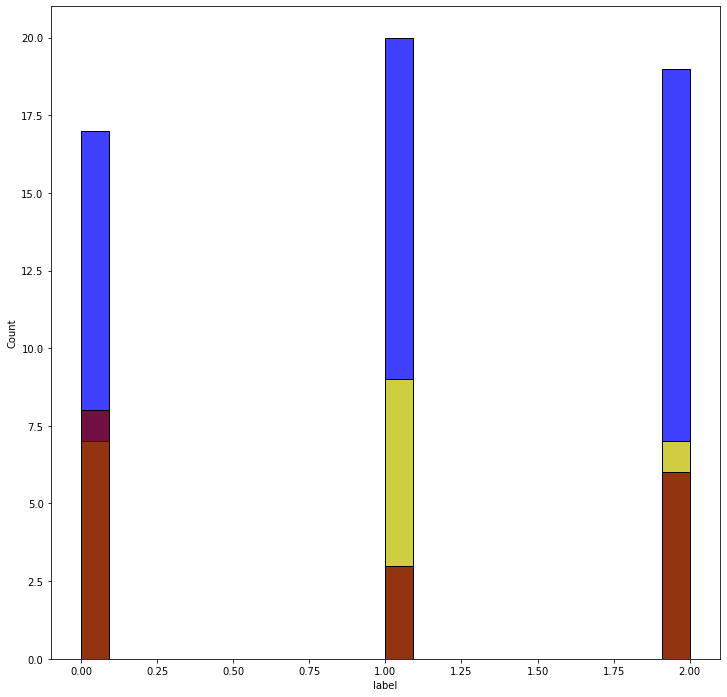

In [15]:
def draw_hist():
    plt.clf()
    fig = plt.figure(figsize=(12, 12))
    train_file = os.path.join(data_root, 'train.json')
    val_file = os.path.join(data_root, 'val.json')
    test_file = os.path.join(data_root, 'test.json')
    df_train = pd.read_json(train_file)
    df_val = pd.read_json(val_file)
    df_test = pd.read_json(test_file)
    for df, co, alpha in ((df_train, 'blue', 0.5), (df_val, 'yellow', 1), (df_test, 'maroon', 0.8)):
        sns.histplot(df['label'],
                 kde=False,
                 color=co,
                 line_kws={"linewidth": 2, "alpha": alpha},
                 bins=22)
    plt.savefig(f'{data_root}/labels_hist.png')
    plt.show()
draw_hist()
